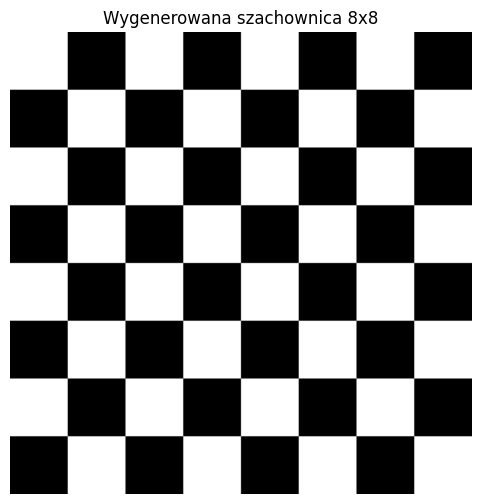

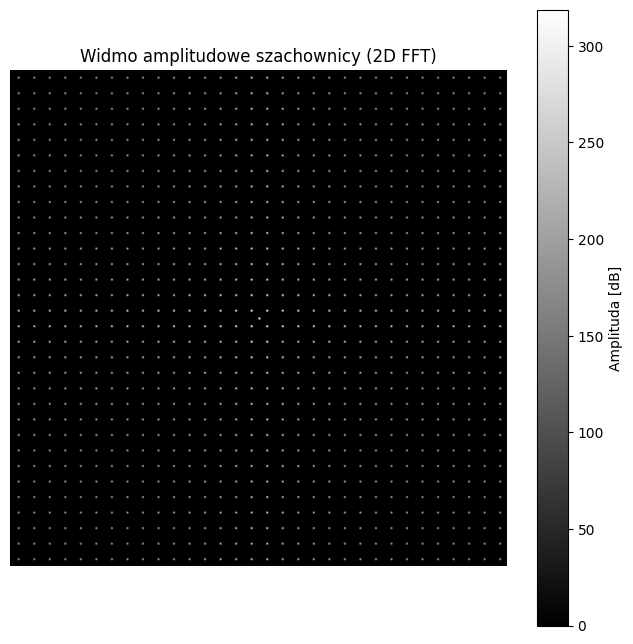

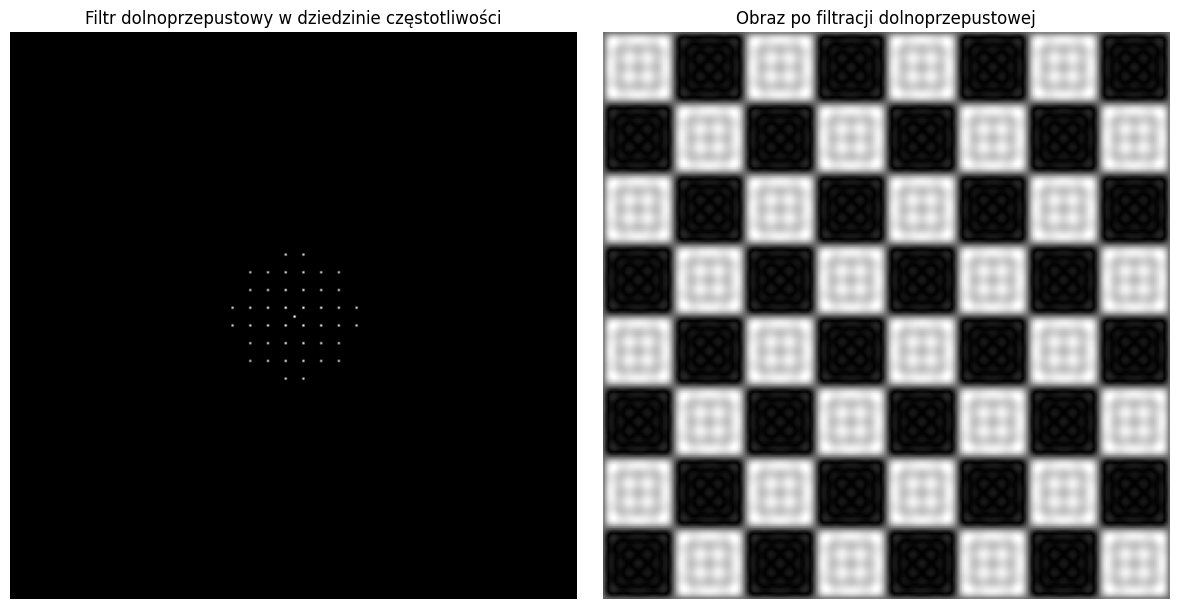

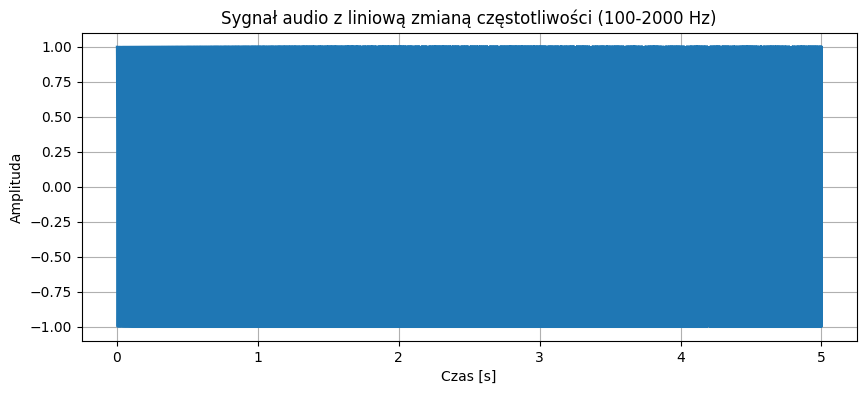

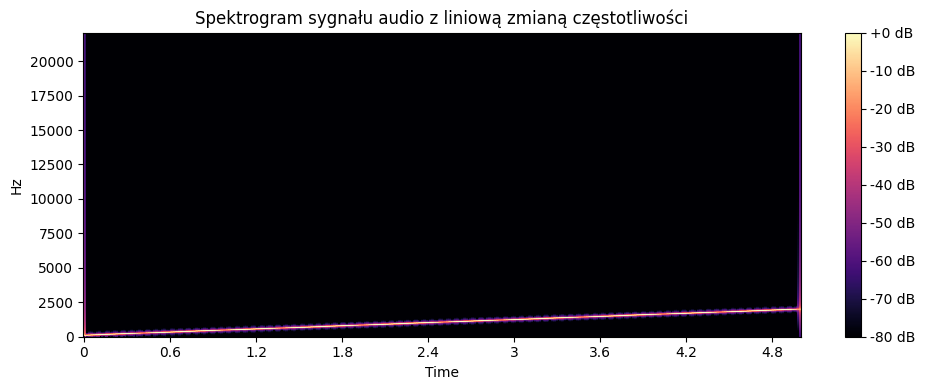

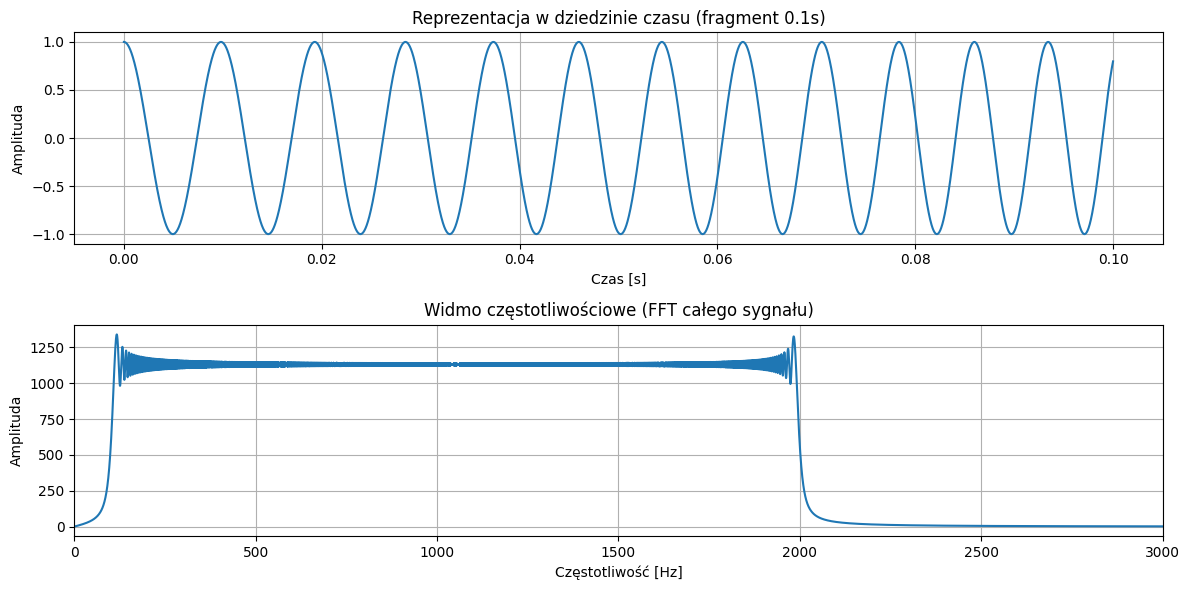

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp
from scipy.io.wavfile import write
import librosa
import librosa.display

# 1. Generowanie szachownicy
def generate_checkerboard(size=256, squares=8):
    """Generuje obraz szachownicy 8x8 używając NumPy"""
    pattern = np.kron([[1, 0] * (squares//2), [0, 1] * (squares//2)] * (squares//2),
                     np.ones((size//squares, size//squares)))
    return (pattern * 255).astype(np.uint8)


checkerboard = generate_checkerboard()
plt.figure(figsize=(6,6))
plt.imshow(checkerboard, cmap='gray')
plt.title('Wygenerowana szachownica 8x8')
plt.axis('off')
plt.show()

# 2. Analiza 2D FFT obrazu szachownicy
f = np.fft.fft2(checkerboard)
fshift = np.fft.fftshift(f)  # Przesunięcie zerowej częstotliwości do środka

# Obliczanie widma amplitudowego (w skali logarytmicznej)
magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)

# Wizualizacja widma
plt.figure(figsize=(8,8))
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Widmo amplitudowe szachownicy (2D FFT)')
plt.colorbar(label='Amplituda [dB]')
plt.axis('off')
plt.show()

# 3. Filtracja w dziedzinie częstotliwości
rows, cols = checkerboard.shape
crow, ccol = rows // 2, cols // 2
r = 30  # Promień maski
# Tworzenie maski filtru dolnoprzepustowego (koło)
y, x = np.ogrid[-crow:rows-crow, -ccol:cols-ccol]
mask_lp = x*x + y*y <= r*r
mask_lp = mask_lp.astype(np.float32)
# Filtracja i odwrotna transformata
fshift_lp = fshift * mask_lp
f_ishift_lp = np.fft.ifftshift(fshift_lp)
img_back_lp = np.fft.ifft2(f_ishift_lp)
img_back_lp = np.abs(img_back_lp)
# Wyświetlanie wyników filtracji
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(magnitude_spectrum * mask_lp, cmap='gray')
plt.title('Filtr dolnoprzepustowy w dziedzinie częstotliwości')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img_back_lp, cmap='gray')
plt.title('Obraz po filtracji dolnoprzepustowej')
plt.axis('off')
plt.tight_layout()
plt.show()

# 4. Generowanie sygnału audio z liniową zmianą częstotliwości
def generate_sine_sweep(f0=100, f1=2000, duration=5, fs=44100):
    """Generuje sygnał audio z liniową zmianą częstotliwości"""
    t = np.linspace(0, duration, int(fs * duration))
    y = chirp(t, f0=f0, f1=f1, t1=duration, method='linear')
    write('sine_sweep.wav', fs, (y * 32767).astype(np.int16))
    return y, fs

# Generowanie i zapis sygnału
y, sr = generate_sine_sweep()

# Wykres sygnału w dziedzinie czasu
plt.figure(figsize=(10,4))
plt.plot(np.linspace(0, 5, len(y)), y)
plt.title('Sygnał audio z liniową zmianą częstotliwości (100-2000 Hz)')
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.grid(True)
plt.show()

# 5. Analiza spektrogramu sygnału audio
# Obliczanie STFT i spektrogramu
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Wizualizacja spektrogramu
plt.figure(figsize=(10,4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Spektrogram sygnału audio z liniową zmianą częstotliwości')
plt.tight_layout()
plt.show()

# 6. Porównanie reprezentacji w dziedzinie czasu i częstotliwości
plt.figure(figsize=(12,6))

# Wykres czasowy (fragment sygnału)
plt.subplot(2,1,1)
plt.plot(np.linspace(0, 0.1, int(sr*0.1)), y[:int(sr*0.1)])
plt.title('Reprezentacja w dziedzinie czasu (fragment 0.1s)')
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.grid(True)

# Widmo częstotliwościowe (FFT)
plt.subplot(2,1,2)
Y = np.fft.fft(y)
freqs = np.fft.fftfreq(len(Y), 1/sr)
plt.plot(freqs[:len(freqs)//2], np.abs(Y[:len(Y)//2]))
plt.title('Widmo częstotliwościowe (FFT całego sygnału)')
plt.xlabel('Częstotliwość [Hz]')
plt.ylabel('Amplituda')
plt.grid(True)
plt.xlim(0, 3000)  # Ograniczenie do zakresu 0-3kHz

plt.tight_layout()
plt.show()